In [1]:
import copy
import gymnasium as gym
import numpy as np
from datetime import datetime, timedelta

In [2]:
class Config():
    def __init__(self):
        self.env_name = "CartPole-v1"
        self.total_episode = 100000
        self.gamma = 0.99
        self.num_action = 2
        self.n_bins = 10
        self.epsilon=1.0
        self.decay_step=int(0.5 * self.total_episode)
        self.eps_min=0.05
        self.lr = 0.1
        self.test_frequency = 10

config = Config()

In [3]:
import numpy as np

class Discretizer:
    def __init__(self, n_bins=6):
        self.n_bins = n_bins
        self.cart_pos_bins = np.linspace(-4.8, 4.8, n_bins - 1)
        self.cart_vel_bins = np.linspace(-3.0, 3.0, n_bins - 1)  
        self.pole_angle_bins = np.linspace(-0.419, 0.419, n_bins - 1)
        self.pole_vel_bins = np.linspace(-3.0, 3.0, n_bins - 1) 

    def discretize(self, state):
        cart_pos, cart_vel, pole_angle, pole_vel = state

        d_cart_pos = np.digitize(cart_pos, self.cart_pos_bins)
        d_cart_vel = np.digitize(cart_vel, self.cart_vel_bins)
        d_pole_angle = np.digitize(pole_angle, self.pole_angle_bins)
        d_pole_vel = np.digitize(pole_vel, self.pole_vel_bins)

        return (d_cart_pos, d_cart_vel, d_pole_angle, d_pole_vel)

    def get_state_index(self, discrete_state):
        d = discrete_state
        return ((d[0] * self.n_bins + d[1]) * self.n_bins + d[2]) * self.n_bins + d[3]

In [4]:
def select_action(Q_Table, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q_Table.shape[1])
    else:
        return np.argmax(Q_Table[state])

In [5]:
def decay_epsilon(epsilon, decay_per_step):
    epsilon = max(epsilon - decay_per_step, config.eps_min)
    return epsilon

In [6]:
def test(config, Q_Table, discretizer):
    env = gym.make(config.env_name)
    state, _ = env.reset()
    state = discretizer.get_state_index(discretizer.discretize(state))
    done = False
    episode_reward = 0.

    while not done:
        action = np.argmax(Q_Table[state])
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = discretizer.get_state_index(discretizer.discretize(next_state))
        episode_reward += reward
        done = terminated or truncated
        state = next_state
    return episode_reward

In [7]:
discretizer = Discretizer(config.n_bins)
Q_Table = np.zeros((config.n_bins**4, config.num_action))
episode_rewards = []
test_episode_rewards = []
epsilon = config.epsilon
decay_per_step = (epsilon - config.eps_min) / config.decay_step
max_test_reward = 0.

for episode in range(1, config.total_episode+1):
    env = gym.make(config.env_name)
    state, _ = env.reset()
    state = discretizer.get_state_index(discretizer.discretize(state))
    done = False

    episode_reward = 0.

    while not done:
        action = select_action(Q_Table, state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = discretizer.get_state_index(discretizer.discretize(next_state))
        episode_reward += reward
        done = terminated or truncated
        if not done:
            next_action = np.argmax(Q_Table[next_state])
            target = Q_Table[next_state, next_action] * config.gamma + reward
        else:
            next_action = -1
            target = reward
        q_sa = Q_Table[state, action]
        Q_Table[state, action] += config.lr * (target - q_sa)
        state = next_state
    
    episode_rewards.append(episode_reward)
    epsilon = decay_epsilon(epsilon, decay_per_step)
    
    if episode % 1000 == 0:
        print(f"Episode: {episode} Rewards: {episode_reward} Mean_Rewards: {np.array(episode_rewards[-min(100, len(episode_rewards)):]).mean():.4f} Epsilon: {epsilon:.4f}")

    if episode % config.test_frequency == 0:
        test_episode_reward = test(config, Q_Table, discretizer)
        test_episode_rewards.append(test_episode_reward)
        max_test_reward = max(max_test_reward, test_episode_reward)
        if len(test_episode_rewards) % 1000 == 0:
            print(f"Test Episode {len(test_episode_rewards)}: Rewards: {test_episode_reward} \
Mean_Rewards: {np.array(test_episode_rewards[-min(100, len(test_episode_rewards)):]).mean():.4f} Max_Rewards: {max_test_reward}")

Episode: 1000 Rewards: 19.0 Mean_Rewards: 24.5400 Epsilon: 0.9810
Episode: 2000 Rewards: 17.0 Mean_Rewards: 23.2800 Epsilon: 0.9620
Episode: 3000 Rewards: 28.0 Mean_Rewards: 23.4500 Epsilon: 0.9430
Episode: 4000 Rewards: 20.0 Mean_Rewards: 24.0100 Epsilon: 0.9240
Episode: 5000 Rewards: 23.0 Mean_Rewards: 27.9300 Epsilon: 0.9050
Episode: 6000 Rewards: 10.0 Mean_Rewards: 27.9200 Epsilon: 0.8860
Episode: 7000 Rewards: 18.0 Mean_Rewards: 26.8300 Epsilon: 0.8670
Episode: 8000 Rewards: 36.0 Mean_Rewards: 28.8400 Epsilon: 0.8480
Episode: 9000 Rewards: 20.0 Mean_Rewards: 30.8600 Epsilon: 0.8290
Episode: 10000 Rewards: 31.0 Mean_Rewards: 31.5400 Epsilon: 0.8100
Test Episode 1000: Rewards: 115.0 Mean_Rewards: 152.0200 Max_Rewards: 500.0
Episode: 11000 Rewards: 13.0 Mean_Rewards: 33.7800 Epsilon: 0.7910
Episode: 12000 Rewards: 103.0 Mean_Rewards: 38.0200 Epsilon: 0.7720
Episode: 13000 Rewards: 26.0 Mean_Rewards: 41.4000 Epsilon: 0.7530
Episode: 14000 Rewards: 40.0 Mean_Rewards: 38.0600 Epsilon: 0

In [10]:
idx_full_rewards = np.array(test_episode_rewards) == 500
print(idx_full_rewards.sum() / len(test_episode_rewards))

0.1212


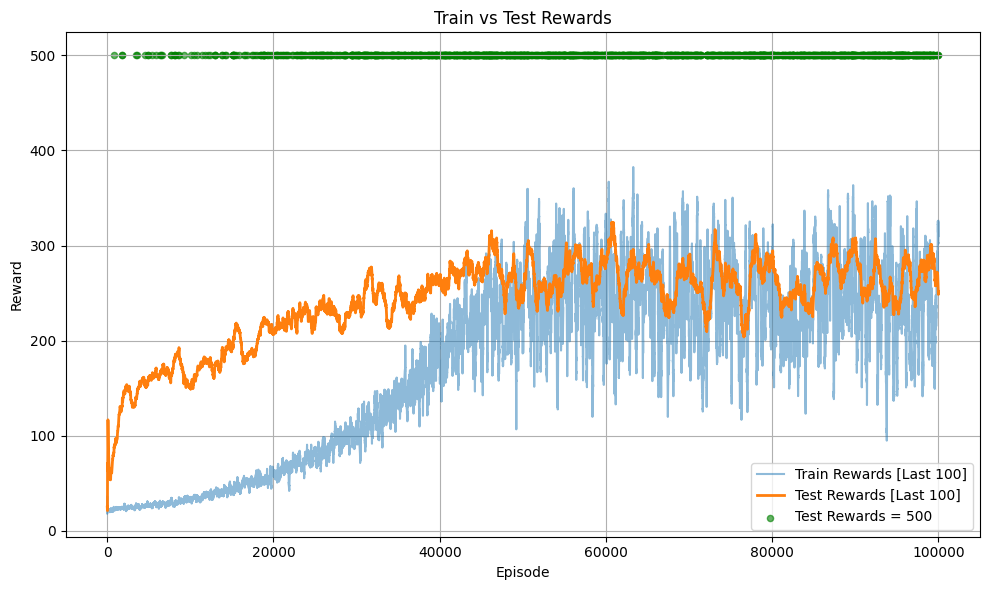

In [8]:
import matplotlib.pyplot as plt

train_episodes = list(range(1, len(episode_rewards)+1))
test_episodes = list(range(10, len(episode_rewards)+1, 10))  # test sau mỗi 10 train episodes (0-based index)

episode_rewards = np.array(episode_rewards)
test_episode_rewards = np.array(test_episode_rewards)

mean_rewards = []
mean_test_rewards = []
for i in range(len(episode_rewards)):
    mean_rewards.append(episode_rewards[max(0, i-100):i+1].mean())
for i in range(len(test_episode_rewards)):
    mean_test_rewards.append(test_episode_rewards[max(0, i-100):i+1].mean())

plt.figure(figsize=(10, 6))

idx_full_rewards = np.array(test_episode_rewards) == 500

plt.plot(train_episodes, mean_rewards, label='Train Rewards [Last 100]', alpha=0.5)
plt.plot(test_episodes, mean_test_rewards, label='Test Rewards [Last 100]', linewidth=2)
plt.scatter(np.array(test_episodes)[idx_full_rewards], 
            np.array(test_episode_rewards)[idx_full_rewards], label='Test Rewards = 500', alpha=0.6, s=20, color = 'green')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Train vs Test Rewards")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

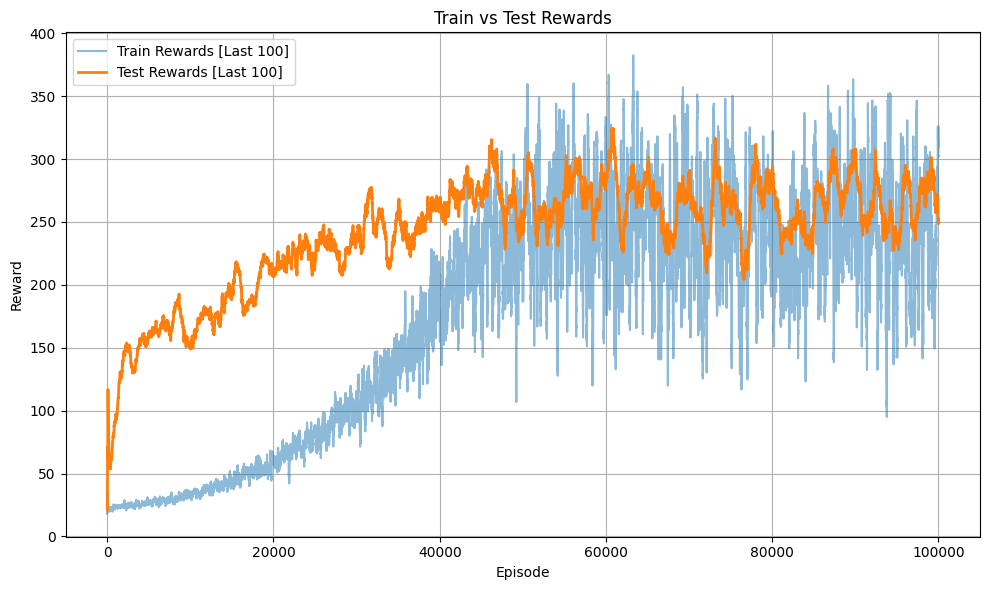

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(train_episodes, mean_rewards, label='Train Rewards [Last 100]', alpha=0.5)
plt.plot(test_episodes, mean_test_rewards, label='Test Rewards [Last 100]', linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Train vs Test Rewards")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()